Telecom Churn Project

In [1]:
!pip install pymysql

In [2]:
import pymysql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection
import pymysql

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)


In [3]:
#loading the data from sql db

def load_telecom_data():
    connection = pymysql.connect(
        host="18.136.157.135",
        user="dm_team3",
        password="DM!$!Team!27@9!20&",
        database="project_telecom",
        cursorclass=pymysql.cursors.DictCursor
    )

    try:
        with connection.cursor() as cursor:
            query = "SELECT * FROM telecom_churn_data"
            cursor.execute(query)
            result = cursor.fetchall()
            df = pd.DataFrame(result)

        return df

    finally:
        connection.close()


df = load_telecom_data()
print(df.shape)

(243553, 14)


Exploratory data analysis

In [4]:
df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,date_of_registration,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,1,Reliance Jio,F,25,Karnataka,Kolkata,755597,2020-01-01,4,124962,44,45,-361,0
1,2,Reliance Jio,F,55,Mizoram,Mumbai,125926,2020-01-01,2,130556,62,39,5973,0
2,3,Vodafone,F,57,Arunachal Pradesh,Delhi,423976,2020-01-01,0,148828,49,24,193,1
3,4,BSNL,M,46,Tamil Nadu,Kolkata,522841,2020-01-01,1,38722,80,25,9377,1
4,5,BSNL,F,26,Tripura,Delhi,740247,2020-01-01,2,55098,78,15,1393,0


In [5]:
df.tail()

,customer_id,telecom_partner,gender,age,state,city,pincode,date_of_registration,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
243548,243549,Airtel,F,28,Mizoram,Kolkata,110295,2023-05-03,3,130580,28,9,4102,0
243549,243550,Reliance Jio,F,52,Assam,Kolkata,713481,2023-05-03,0,82393,80,45,7521,0
243550,243551,Reliance Jio,M,59,Tripura,Kolkata,520218,2023-05-03,4,51298,26,4,6547,0
243551,243552,BSNL,M,49,Madhya Pradesh,Kolkata,387744,2023-05-03,2,83981,80,15,1125,0
243552,243553,BSNL,F,37,Telangana,Hyderabad,139086,2023-05-04,0,144297,61,7,3384,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243553 entries, 0 to 243552
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   customer_id           243553 non-null  int64 
 1   telecom_partner       243553 non-null  object
 2   gender                243553 non-null  object
 3   age                   243553 non-null  int64 
 4   state                 243553 non-null  object
 5   city                  243553 non-null  object
 6   pincode               243553 non-null  int64 
 7   date_of_registration  243553 non-null  object
 8   num_dependents        243553 non-null  int64 
 9   estimated_salary      243553 non-null  int64 
 10  calls_made            243553 non-null  int64 
 11  sms_sent              243553 non-null  int64 
 12  data_used             243553 non-null  int64 
 13  churn                 243553 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 26.0+ MB


In [7]:
df.skew(numeric_only=True)
#to check if any column needs log transformation

customer_id         0.000000
age                -0.007563
pincode             0.004915
num_dependents      0.001801
estimated_salary    0.000973
calls_made         -0.002494
sms_sent            0.005314
data_used           0.003788
churn               1.496280
dtype: float64

In [8]:
df.isnull().sum()

customer_id             0
telecom_partner         0
gender                  0
age                     0
state                   0
city                    0
pincode                 0
date_of_registration    0
num_dependents          0
estimated_salary        0
calls_made              0
sms_sent                0
data_used               0
churn                   0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.describe()

,customer_id,age,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
count,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000
mean,121777.000000,46.077609,549501.270541,1.997500,85021.137839,49.010548,23.945404,4993.186025,0.200478
std,70307.839393,16.444029,259808.860574,1.414941,37508.963233,29.453556,14.733575,2942.019547,0.400359
min,1.000000,18.000000,100006.000000,0.000000,20000.000000,-10.000000,-5.000000,-987.000000,0.000000
25%,60889.000000,32.000000,324586.000000,1.000000,52585.000000,24.000000,11.000000,2490.000000,0.000000
50%,121777.000000,46.000000,548112.000000,2.000000,84990.000000,49.000000,24.000000,4987.000000,0.000000
75%,182665.000000,60.000000,774994.000000,3.000000,117488.000000,74.000000,36.000000,7493.000000,0.000000
max,243553.000000,74.000000,999987.000000,4.000000,149999.000000,108.000000,53.000000,10991.000000,1.000000


In [11]:
#Checking unique values in each column
for col in df.columns:
    print(f"{df[col]} = {df[col].value_counts()}")

0              1
1              2
2              3
3              4
4              5
           ...  
243548    243549
243549    243550
243550    243551
243551    243552
243552    243553
Name: customer_id, Length: 243553, dtype: int64 = customer_id
243553    1
243537    1
243536    1
243535    1
243534    1
         ..
6         1
5         1
4         1
3         1
2         1
Name: count, Length: 243553, dtype: int64
0         Reliance Jio
1         Reliance Jio
2             Vodafone
3                 BSNL
4                 BSNL
              ...     
243548          Airtel
243549    Reliance Jio
243550    Reliance Jio
243551            BSNL
243552            BSNL
Name: telecom_partner, Length: 243553, dtype: object = telecom_partner
Reliance Jio    61123
Airtel          60905
Vodafone        60802
BSNL            60723
Name: count, dtype: int64
0         F
1         F
2         F
3         M
4         F
         ..
243548    F
243549    F
243550    M
243551    M
243552    F
Name: g

In [12]:
print(df['churn'].value_counts())
print(df['churn'].value_counts(normalize=True))
#Approximately 79.96% people stayed and 20% left

churn
0    194726
1     48827
Name: count, dtype: int64
churn
0    0.799522
1    0.200478
Name: proportion, dtype: float64


<Axes: xlabel='churn', ylabel='count'>

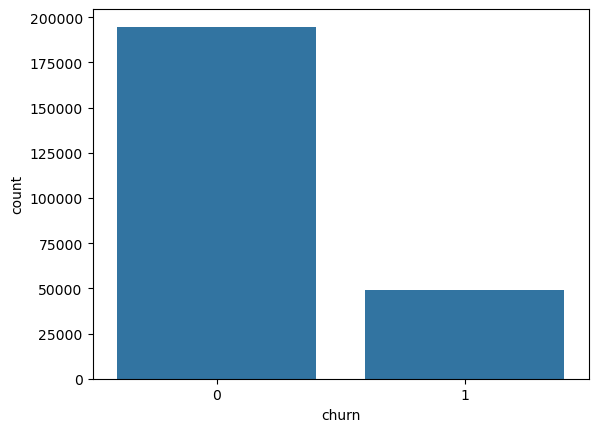

In [13]:
sns.countplot(x='churn', data=df)

Axes(0.125,0.11;0.775x0.77)


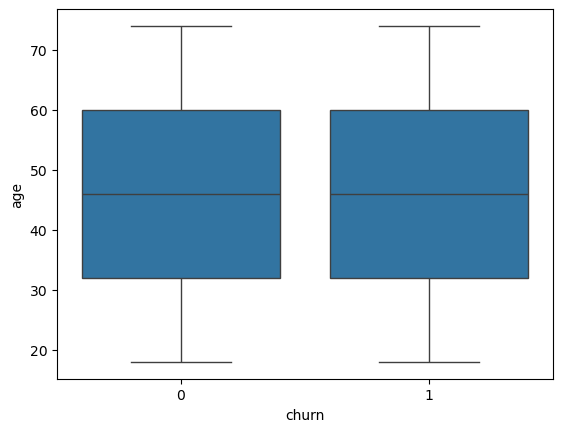

In [14]:
print(sns.boxplot(x='churn', y='age', data=df))

Axes(0.125,0.11;0.775x0.77)


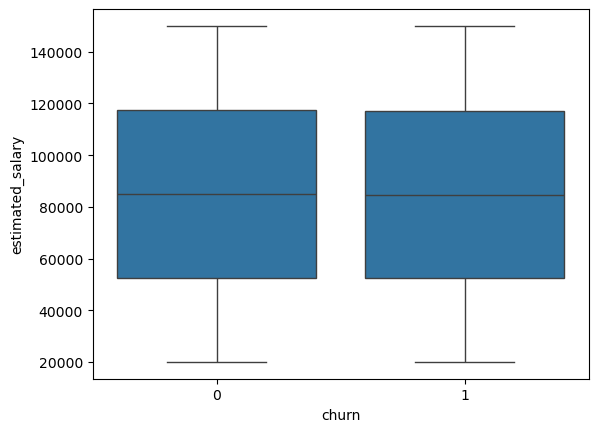

In [15]:
print(sns.boxplot(x='churn', y='estimated_salary', data=df))

Axes(0.125,0.11;0.775x0.77)


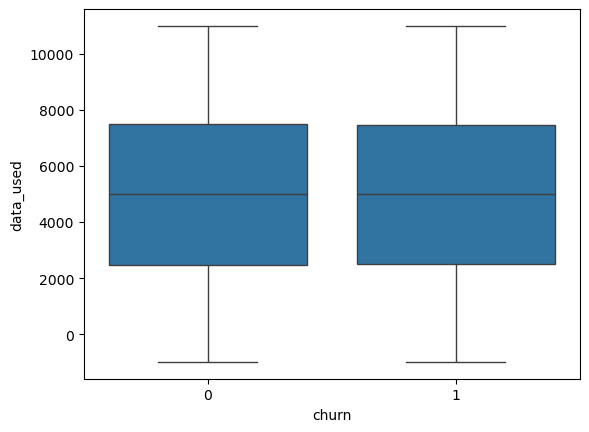

In [16]:
print(sns.boxplot(x='churn', y='data_used', data=df))

In [17]:
df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
tenure_days= (pd.Timestamp.today() - df['date_of_registration']).dt.days

<Axes: xlabel='churn', ylabel='date_of_registration'>

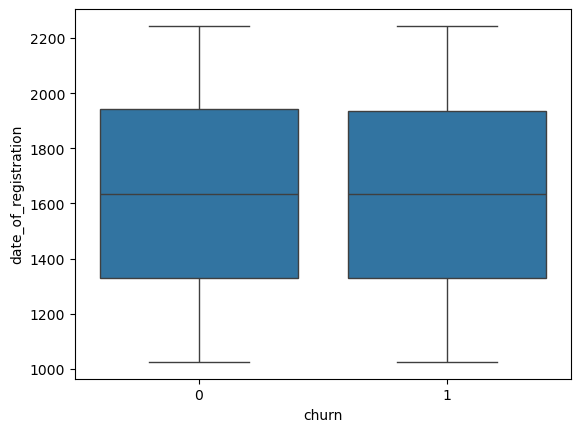

In [18]:
sns.boxplot(x='churn', y=tenure_days, data=df)

In [19]:
#To handle negative values
cols_to_fix = ['calls_made', 'sms_sent', 'data_used']

for col in cols_to_fix:
    df[col] = df[col].apply(lambda x: x if x >= 0 else 0)

print(df[cols_to_fix].describe().loc['min'])

calls_made    0.0
sms_sent      0.0
data_used     0.0
Name: min, dtype: float64


In [20]:
avg_monthly_calls = df['calls_made'] /(tenure_days/30 + 1)
avg_monthly_data= df['data_used'] / (tenure_days/30 + 1)

<Axes: xlabel='churn', ylabel='None'>

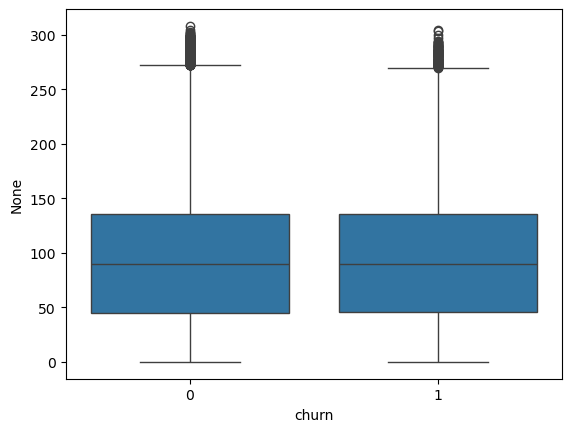

In [21]:
sns.boxplot(x='churn', y=avg_monthly_data, data=df)

From the above box plot, we can confirm that age , data-used, estimated salary,date of registration, call doesnot influence the churn

In [22]:
corr_with_target = df.corr(numeric_only=True)['churn'].sort_values(ascending=False)
print(corr_with_target)

churn               1.000000
calls_made          0.001771
customer_id         0.001649
pincode             0.001019
age                 0.000839
data_used           0.000763
num_dependents     -0.002543
sms_sent           -0.003086
estimated_salary   -0.003332
Name: churn, dtype: float64


In [23]:
pd.crosstab(df['gender'], df['churn'], normalize='index')

churn,0,1
gender,,
F,0.797030,0.202970
M,0.801188,0.198812


In [24]:
pd.crosstab(df['telecom_partner'], df['churn'], normalize='index')

churn,0,1
telecom_partner,,
Airtel,0.796339,0.203661
BSNL,0.801393,0.198607
Reliance Jio,0.799846,0.200154
Vodafone,0.800516,0.199484


In [25]:
pd.crosstab(df['state'], df['churn'], normalize='index')

churn,0,1
state,,
Andhra Pradesh,0.801480,0.198520
Arunachal Pradesh,0.801073,0.198927
Assam,0.797005,0.202995
Bihar,0.803660,0.196340
Chhattisgarh,0.805693,0.194307
Goa,0.800437,0.199563
Gujarat,0.799768,0.200232
Haryana,0.799657,0.200343
Himachal Pradesh,0.795900,0.204100


In [26]:
pd.crosstab(df['city'], df['churn'], normalize='index')

churn,0,1
city,,
Bangalore,0.799498,0.200502
Chennai,0.802449,0.197551
Delhi,0.802501,0.197499
Hyderabad,0.795838,0.204162
Kolkata,0.798431,0.201569
Mumbai,0.798420,0.201580


<Axes: xlabel='date_of_registration', ylabel='None'>

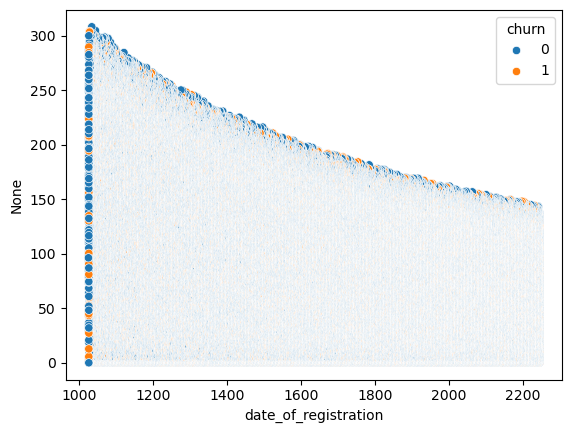

In [27]:
sns.scatterplot(x=tenure_days, y=avg_monthly_data, hue='churn', data=df)

<Axes: xlabel='estimated_salary', ylabel='Count'>

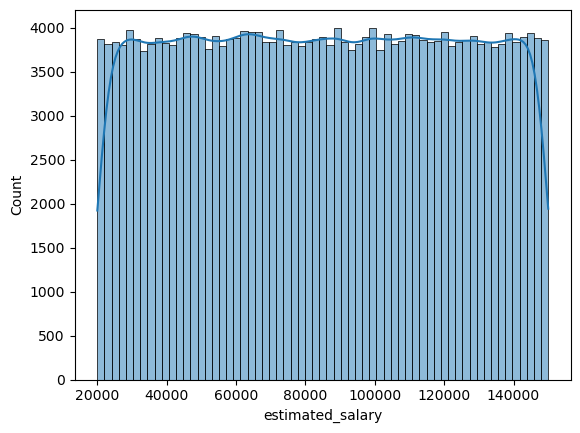

In [28]:
sns.histplot(df['estimated_salary'], kde=True)
#People are distributed evenly across all salary brackets.

In [29]:
df.groupby(pd.qcut(tenure_days, 4))['churn'].mean()
#As seen in your qcut analysis, churn is remarkably consistent (around 20%) regardless of how long a customer has been registered (tenure)

C:\Users\SRUTHI\AppData\Local\Temp\ipykernel_13392\1582782478.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(tenure_days, 4))['churn'].mean()


date_of_registration
(1024.999, 1330.0]    0.200515
(1330.0, 1635.0]      0.201927
(1635.0, 1940.0]      0.201090
(1940.0, 2244.0]      0.198373
Name: churn, dtype: float64

C:\Users\SRUTHI\AppData\Local\Temp\ipykernel_13392\2132340247.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['telecom_partner'].index, y=df['telecom_partner'].values, palette='viridis')


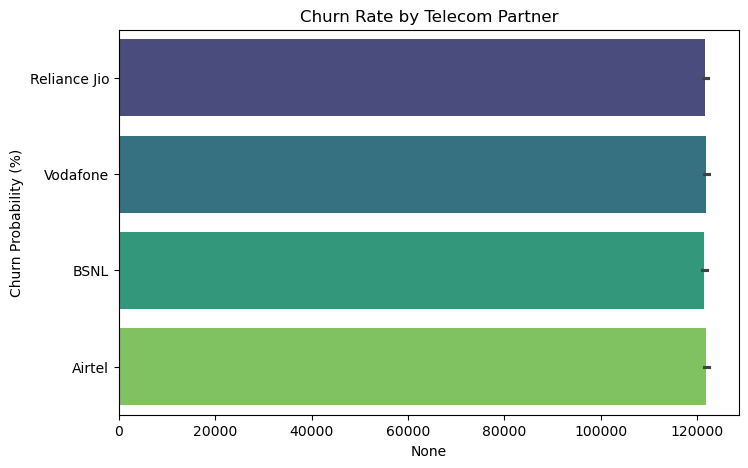

In [30]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df['telecom_partner'].index, y=df['telecom_partner'].values, palette='viridis')

plt.title('Churn Rate by Telecom Partner')
plt.ylabel('Churn Probability (%)')
plt.show()

In [31]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | 
                    (data[column] > upper_bound)]

    return outliers

for col in numeric_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")


customer_id: 0 outliers
age: 0 outliers
pincode: 0 outliers
num_dependents: 0 outliers
estimated_salary: 0 outliers
calls_made: 0 outliers
sms_sent: 0 outliers
data_used: 0 outliers
churn: 48827 outliers


In [32]:
df = df.drop(['customer_id', 'pincode','city'], axis=1)

In [34]:
df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
df['tenure_days'] = (pd.Timestamp.today() - df['date_of_registration']).dt.days
df['tenure_months'] = df['tenure_days'] / 30

df.drop('date_of_registration', axis=1, inplace=True)


In [35]:
df['total_usage'] = df['calls_made'] + df['sms_sent'] + df['data_used']
df['usage_per_month'] = df['total_usage'] / (df['tenure_months'] + 1)


In [36]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [37]:
categorical_cols = ['telecom_partner', 'gender', 'state']
numeric_cols = [col for col in X.columns if col not in categorical_cols]


In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)


In [58]:
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

log_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'num_dependents',
                                                   'estimated_salary',
                                                   'calls_made', 'sms_sent',
                                                   'data_used', 'tenure_days',
                                                   'tenure_months',
                                                   'total_usage',
                                                   'usage_per_month']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['telecom_partner', 'gender',
                                                   'state'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression())])

In [59]:
y_pred = log_model.predict(X_test)
y_proba = log_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.80      0.78      0.79     38946
           1       0.21      0.23      0.22      9765

    accuracy                           0.67     48711
   macro avg       0.50      0.50      0.50     48711
weighted avg       0.68      0.67      0.67     48711

ROC-AUC: 0.5070533651317963


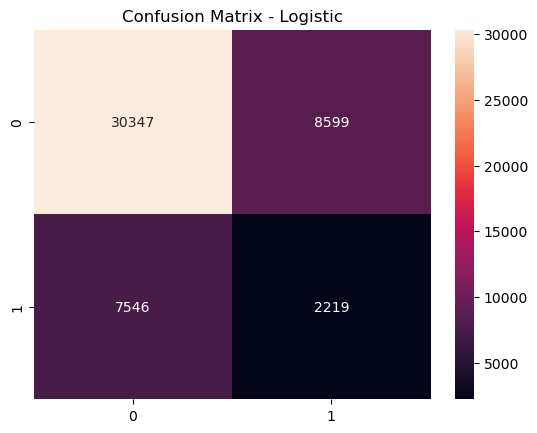

In [60]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Logistic")
plt.show()


In [42]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'num_dependents',
                                                   'estimated_salary',
                                                   'calls_made', 'sms_sent',
                                                   'data_used', 'tenure_days',
                                                   'tenure_months',
                                                   'total_usage',
                                                   'usage_per_month']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['telecom_partner', 'gender',
                                                   'state'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [43]:
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89     38946
           1       0.00      0.00      0.00      9765

    accuracy                           0.80     48711
   macro avg       0.40      0.50      0.44     48711
weighted avg       0.64      0.80      0.71     48711

ROC-AUC: 0.49954934647784793


C:\Users\SRUTHI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SRUTHI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SRUTHI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


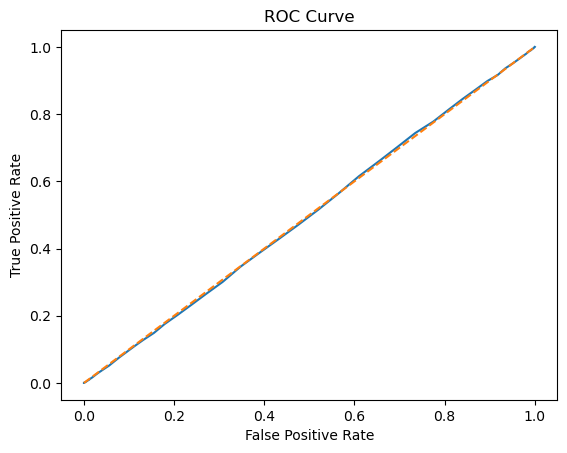

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [45]:
for t in [0.5, 0.4, 0.35, 0.3, 0.25]:
    pred = (y_proba_rf >= t).astype(int)
    print(f"Threshold: {t}")
    print(classification_report(y_test, pred))
#threshold is used to convert predicted probabilities into final class decisions

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     38946
           1       0.00      0.00      0.00      9765

    accuracy                           0.80     48711
   macro avg       0.40      0.50      0.44     48711
weighted avg       0.64      0.80      0.71     48711

Threshold: 0.4
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     38946
           1       0.09      0.00      0.00      9765

    accuracy                           0.80     48711
   macro avg       0.45      0.50      0.44     48711
weighted avg       0.66      0.80      0.71     48711

Threshold: 0.35
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     38946
           1       0.14      0.00      0.00      9765

    accuracy                           0.80     48711
   macro avg       0.47      0.50      0.45     48711
weighted avg       0.67     

C:\Users\SRUTHI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SRUTHI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SRUTHI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold tuning is not helping because: There is no meaningful probability separation.

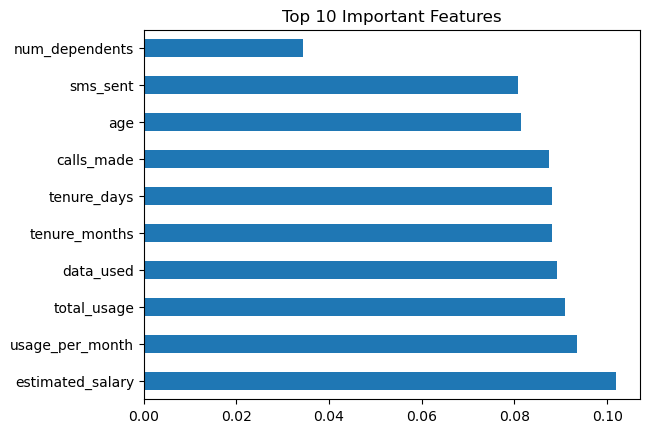

In [46]:
feature_names = (
    numeric_cols +
    list(rf_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

importances = rf_model.named_steps['classifier'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp.head(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()


In [47]:
smote_rf_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ))
])

smote_rf_model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'num_dependents',
                                                   'estimated_salary',
                                                   'calls_made', 'sms_sent',
                                                   'data_used', 'tenure_days',
                                                   'tenure_months',
                                                   'total_usage',
                                                   'usage_per_month']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['telecom_partner', 'gender',
                                                   'state'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

In [48]:
y_pred_smote = smote_rf_model.predict(X_test)
y_proba_smote = smote_rf_model.predict_proba(X_test)[:,1]

print("SMOTE Random Forest Results")
print(classification_report(y_test, y_pred_smote))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_smote))


SMOTE Random Forest Results
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     38946
           1       0.20      0.01      0.01      9765

    accuracy                           0.80     48711
   macro avg       0.50      0.50      0.45     48711
weighted avg       0.68      0.80      0.71     48711

ROC-AUC: 0.5005652830738185


In [49]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ))
])


In [50]:
param_grid = {
    'classifier__n_estimators': [200, 400],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}


In [51]:
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\SRUTHI\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:34:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'num_dependents',
                                                                          'estimated_salary',
                                                                          'calls_made',
                                                                          'sms_sent',
                                                                          'data_used',
                                                                          'tenure_days',
                                                                          'tenure_months',
                                                                          'total_usage',
                                                                          'usage_per_month']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['telecom_partner',
                                                                          'gender',
                                                                          'state'])])),
                                       ('classifier',
                                        X...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [200, 400],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [52]:
best_xgb = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)


Best Parameters:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 400, 'classifier__subsample': 1.0}


In [53]:
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:,1]

print("Tuned XGBoost Results")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


Tuned XGBoost Results
              precision    recall  f1-score   support

           0       0.80      0.51      0.63     38946
           1       0.20      0.48      0.28      9765

    accuracy                           0.51     48711
   macro avg       0.50      0.50      0.45     48711
weighted avg       0.68      0.51      0.56     48711

ROC-AUC: 0.49757072490435306


In [54]:
print("After Threshold Adjustment")
for t in [0.5, 0.4, 0.35, 0.3, 0.25]:
    custom_pred_xgb = (y_proba_xgb >= t).astype(int)
    print(f"Threshold: {t}")
    print(classification_report(y_test, custom_pred_xgb))
    print(roc_auc_score(y_test, custom_pred_xgb))


After Threshold Adjustment
Threshold: 0.5
              precision    recall  f1-score   support

           0       0.80      0.51      0.63     38946
           1       0.20      0.48      0.28      9765

    accuracy                           0.51     48711
   macro avg       0.50      0.50      0.45     48711
weighted avg       0.68      0.51      0.56     48711

0.4990347578824924
Threshold: 0.4
              precision    recall  f1-score   support

           0       0.75      0.01      0.02     38946
           1       0.20      0.99      0.33      9765

    accuracy                           0.21     48711
   macro avg       0.48      0.50      0.17     48711
weighted avg       0.64      0.21      0.08     48711

0.4987068313028327
Threshold: 0.35
              precision    recall  f1-score   support

           0       0.76      0.00      0.01     38946
           1       0.20      1.00      0.33      9765

    accuracy                           0.20     48711
   macro avg     

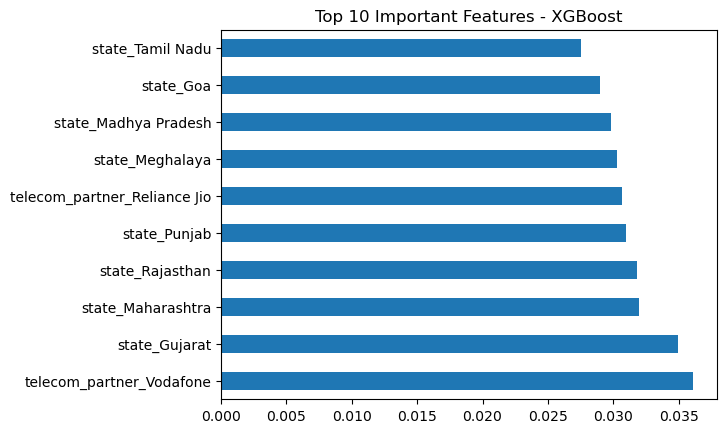

In [55]:
feature_names = (
    numeric_cols +
    list(best_xgb.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

importances = best_xgb.named_steps['classifier'].feature_importances_

feat_imp_xgb = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp_xgb.head(10).plot(kind='barh')
plt.title("Top 10 Important Features - XGBoost")
plt.show()


In [56]:
results = pd.DataFrame({
    "Model": ["Logistic", "RandomForest", "SMOTE_RF", "Tuned_XGBoost"],
    "ROC_AUC": [
        roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_smote),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

results


,Model,ROC_AUC
0,Logistic,0.507053
1,RandomForest,0.499549
2,SMOTE_RF,0.500565
3,Tuned_XGBoost,0.497571


In [57]:
df['churn_probability'] = rf_model.predict_proba(X)[:,1]

threshold = 0.35
df['CHURN_FLAG'] = np.where(df['churn_probability'] >= threshold, 1, 0)

df[['churn_probability', 'CHURN_FLAG']].head()


,churn_probability,CHURN_FLAG
0,0.070,0
1,0.045,0
2,0.710,1
3,0.740,1
4,0.090,0


Interpretation:

All models produced ROC-AUC values close to 0.50, indicating performance equivalent to random guessing.

This means the models were unable to meaningfully distinguish between churners and non-churners using the available features.

An ROC-AUC ≈ 0.50 suggests:

The predictor variables do not contain strong separable patterns.

Churn behavior is not strongly explained by current demographic and aggregate usage features.

Increasing model complexity (Random Forest, XGBoost) did not improve performance, confirming that the limitation is data-driven rather than algorithm-driven.

This is an important analytical finding.

The issue is not model tuning — it is insufficient predictive signal in the dataset.

The dataset contains mostly:

Demographic attributes (age, gender, state)

Aggregate usage metrics (calls, SMS, data)

Estimated salary

Tenure

However, effective churn prediction in telecom typically requires behavioral and dissatisfaction indicators such as:

Complaint frequency

Network performance issues

Plan type and plan changes

Billing/payment history

Late payments

Customer service interactions

Contract type (prepaid/postpaid)

Offer and promotion history

These variables are absent in the current dataset.

As a result, churn appears statistically close to random with respect to available features.